**Description**
- Class 0: combine of GI, GWI and NI (orange)
- Class 1: MediumFI (gray)
- Class 2: OW (darkblue)
- Class 3: ThickFI (purple)
- Class 4: ThinFI (silver)


In [1]:
import torch
from torchvision import transforms
from torchvision.models import efficientnet_b0
from torch import nn
from PIL import Image
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.colors import ListedColormap

# Load the pre-trained EfficientNet-B0 model
model = efficientnet_b0(pretrained=True)
# Modify the first layer for single-channel input
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
# Modify the classifier for the number of output classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)
# load the trained model (70:15:15 ratio)
model.load_state_dict(torch.load('fine_HH5_efficientnet2.pth'))
model.eval()

# Load the pre-processed Sentinel-1 img
img = tiff.imread('subset_3_of_S1A_EW_GRDM_1SDH_20240405T211859_20240405T211959_053304_067647_844B_Bdr_tnr_Spk_Cal_dB_TC.tif')

# image dimensions
h, w = img.shape[1], img.shape[2]

# 500x500 subset from the center of the img
subset_size = 500
center_x, center_y = w // 2, h // 2
half_size = subset_size // 2

subset_img = img[:, center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size]

# select the HH band (1st band)
hh_band = subset_img[0, :, :]

# image type should be float32
hh_band = hh_band.astype(np.float32)

# prepare the image for the model
transform = transforms.Compose([
    transforms.ToTensor(),
])

# classify each part of the entire image area by overlapping
sea_ice_classes = np.zeros_like(hh_band) #initialize an array with zeros to store the classification results for each part of the image

patch_size = 32 #due to model, like the training samples 32x32
stride = 1  #stride which is the step size for sliding the window (1 pixel shift every time)

# timing
#calculate the total number of steps required to cover the entire image
total_steps = (hh_band.shape[0] - patch_size + 1) * (hh_band.shape[1] - patch_size + 1)
step_count = 0

#start timing - process to monitor performance
start_time = time.time()

# loops over the entire image with a sliding window approach
for i in range(0, hh_band.shape[0] - patch_size + 1, stride):
    for j in range(0, hh_band.shape[1] - patch_size + 1, stride):
        patch = hh_band[i:i+patch_size, j:j+patch_size] #extract 32x32 patches
        patch_img = Image.fromarray(patch) #convert the patch to img format- suitable for the model
        input_tensor = transform(patch_img).unsqueeze(0) #transform the img into a tensor
        output = model(input_tensor) #to get the output predictions
        _, predicted = torch.max(output, 1) #the highest predicted probability
        sea_ice_classes[i, j] = predicted.item() #assign the predicted class to the corresponding pixel

        # timing - update and print progress
        step_count += 1
        if step_count % 1000 == 0 or step_count == total_steps:  #print every 1000 steps or at the end
            progress_percentage = (step_count / total_steps) * 100
            elapsed_time = time.time() - start_time
            print(f'Progress: {progress_percentage:.2f}% - Elapsed Time: {elapsed_time:.2f} seconds', end='\r')

#calculate the percentage of each class
unique, counts = np.unique(sea_ice_classes, return_counts=True)
total_pixels = np.sum(counts)
class_percentages = {f'Class {int(cls)}': (count / total_pixels) * 100 for cls, count in zip(unique, counts)}


C:\Users\co1st\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\co1st\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\co1st\AppData\Local\Temp\ipykernel_25520\3967345825.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/b

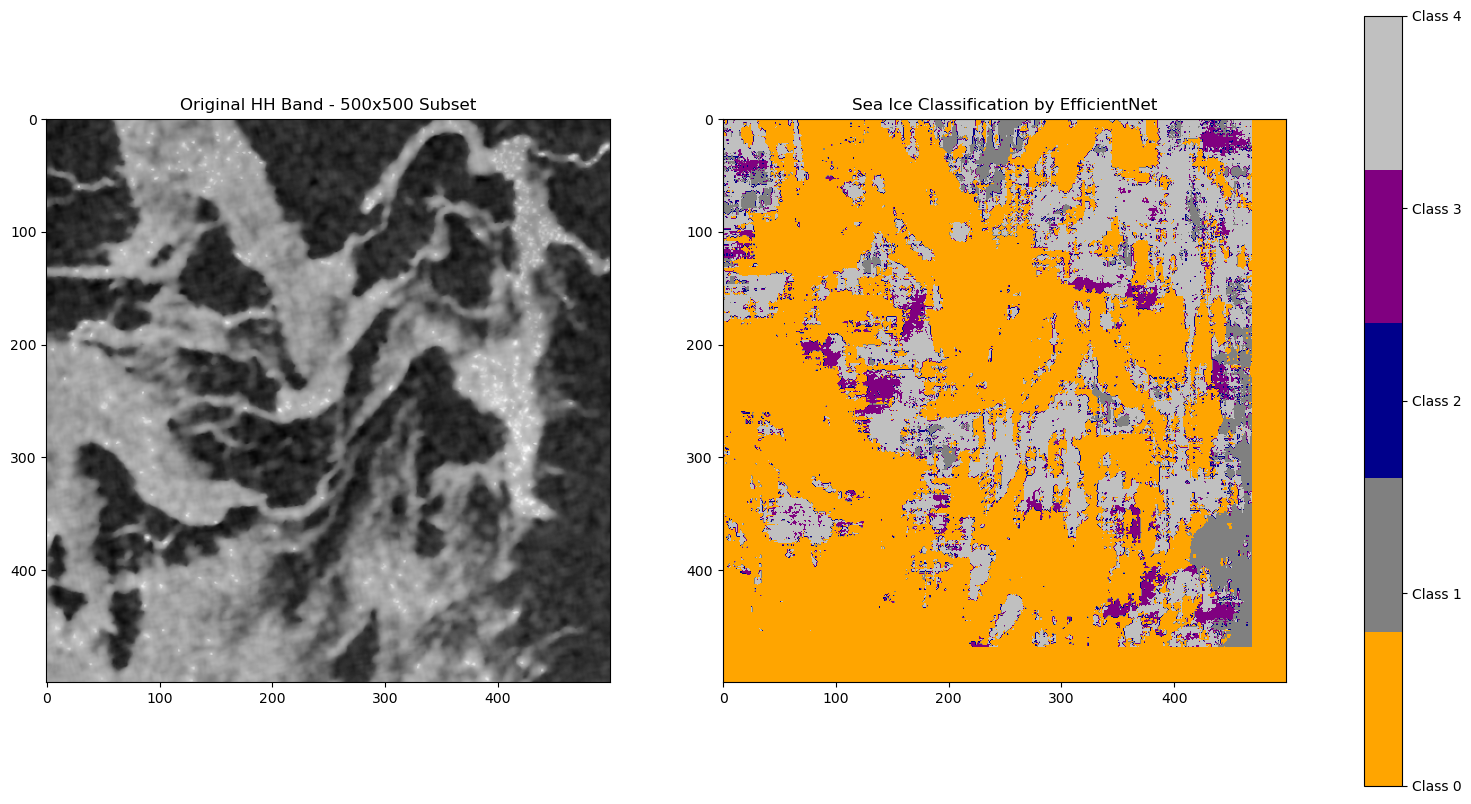

Class Percentages:
Class 0: 67.10%
Class 1: 5.49%
Class 3: 3.67%
Class 4: 23.73%


In [2]:
# Plot original and classified img

#special colors for each class
colors = ['orange', 'gray', 'darkblue', 'purple', 'silver']
cmap = ListedColormap(colors)

#plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#original img
ax[0].imshow(hh_band, cmap='gray')
ax[0].set_title('Original HH Band - 500x500 Subset')
#classified img
im = ax[1].imshow(sea_ice_classes, cmap=cmap, vmin=0, vmax=4)
ax[1].set_title('Sea Ice Classification by EfficientNet')

# color bar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='vertical', ticks=[0, 1, 2, 3, 4])
cbar.ax.set_yticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])

plt.show()

# print percentages
print("Class Percentages:")
for class_label, percentage in class_percentages.items():
    print(f'{class_label}: {percentage:.2f}%')

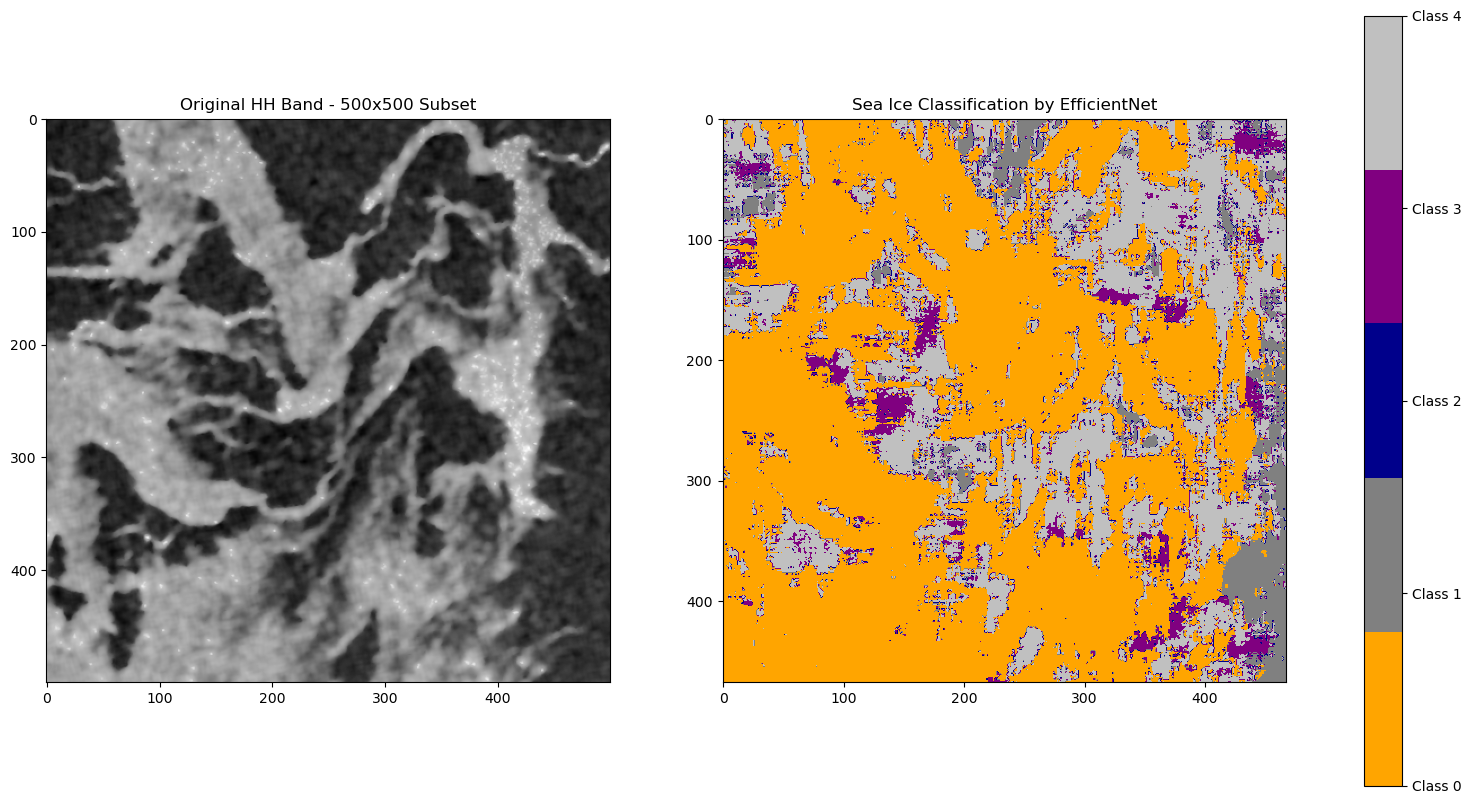

Class Percentages:
Class 0: 62.69%
Class 1: 6.14%
Class 3: 4.18%
Class 4: 26.99%


In [3]:
# after the classification loop, remove the last 32 rows and columns to solve the problem. zeroes of the right and bottom edges
sea_ice_classes = sea_ice_classes[:-32, :-32]



#rest code is same...

#calculate the percentage of each class
unique, counts = np.unique(sea_ice_classes, return_counts=True)
total_pixels = np.sum(counts)
class_percentages = {f'Class {int(cls)}': (count / total_pixels) * 100 for cls, count in zip(unique, counts)}


# Plot original and classified img

#special colors for each class
colors = ['orange', 'gray', 'darkblue', 'purple', 'silver']
cmap = ListedColormap(colors)

#plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#original img
ax[0].imshow(hh_band, cmap='gray')
ax[0].set_title('Original HH Band - 500x500 Subset')
#classified img
im = ax[1].imshow(sea_ice_classes, cmap=cmap, vmin=0, vmax=4)
ax[1].set_title('Sea Ice Classification by EfficientNet')

# color bar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='vertical', ticks=[0, 1, 2, 3, 4])
cbar.ax.set_yticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])

plt.show()

# print percentages
print("Class Percentages:")
for class_label, percentage in class_percentages.items():
    print(f'{class_label}: {percentage:.2f}%')

In [4]:
#save the classified image
plt.imsave('cs_efficientNet.png', sea_ice_classes, cmap=cmap, vmin=0, vmax=4)


In [5]:
#save the subset image too
plt.imsave('original_sub500hh.png', hh_band, cmap='gray')

Since 32 pixels are deleted from both edges, 500-32, 468x468 pixel images are obtained.